# Find all xy curves and fit Gaussians, output csv files

In [1]:
# Import necessary modules
import os
import math
import cmath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, FormatStrFormatter
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
import scipy.constants as constants
import seaborn as sns
import sympy as sp
from sympy import symbols, diff
from collections import defaultdict
from IPython.display import Image, HTML, Markdown
import openpyxl
import xlrd
import glob
%run define_functions.ipynb

C:\Users\au302163\AppData\Local\Temp\ipykernel_16756\3123838228.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]})


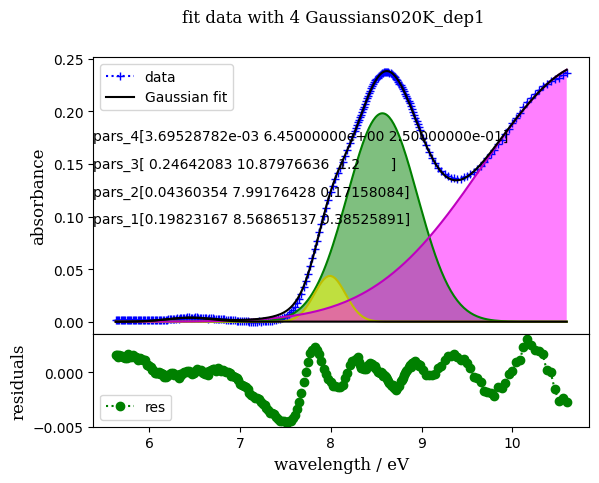

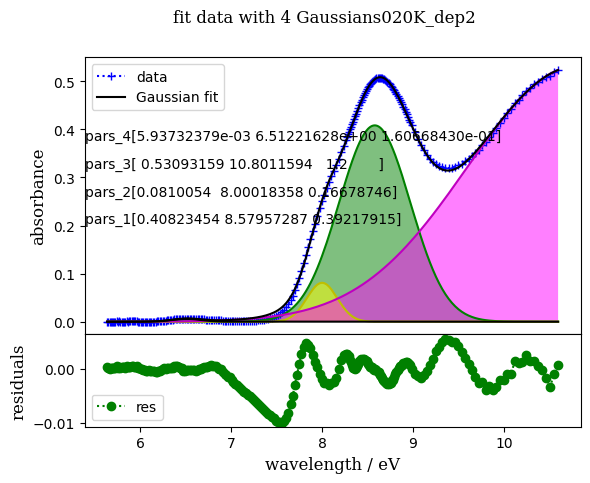

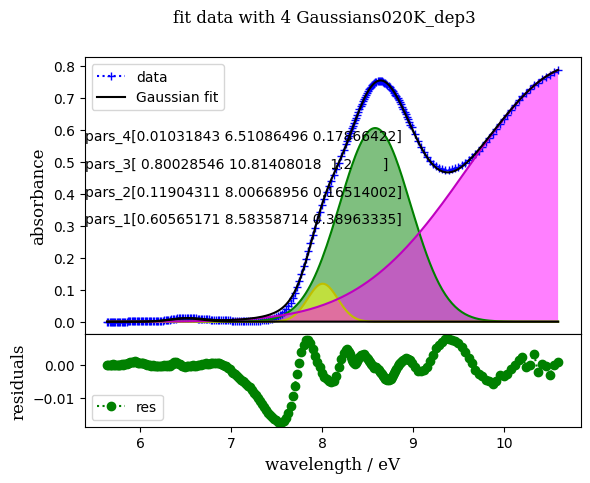

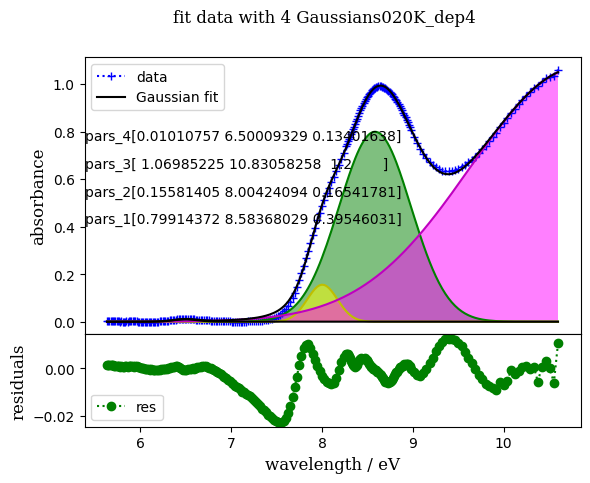

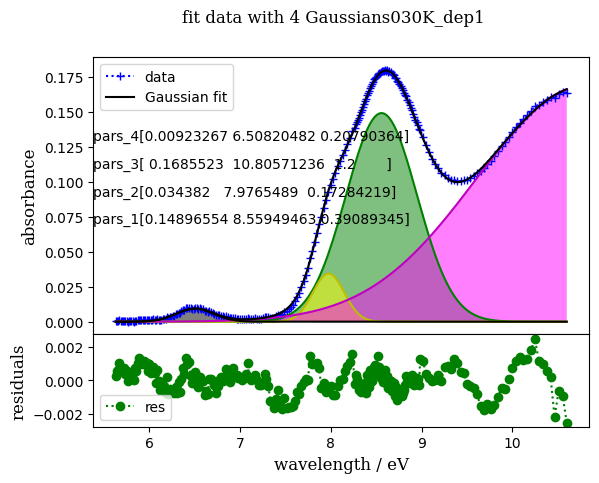

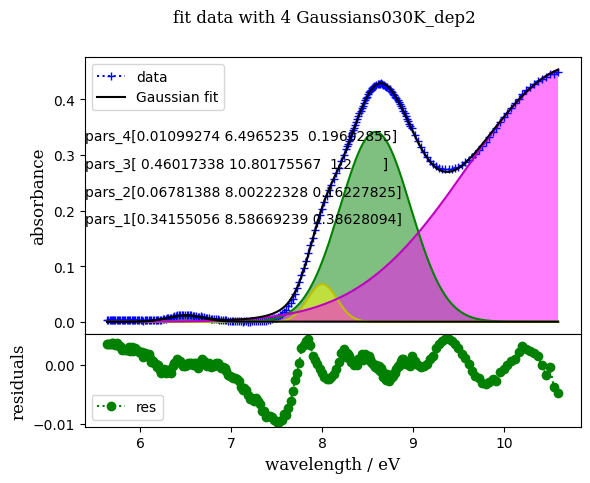

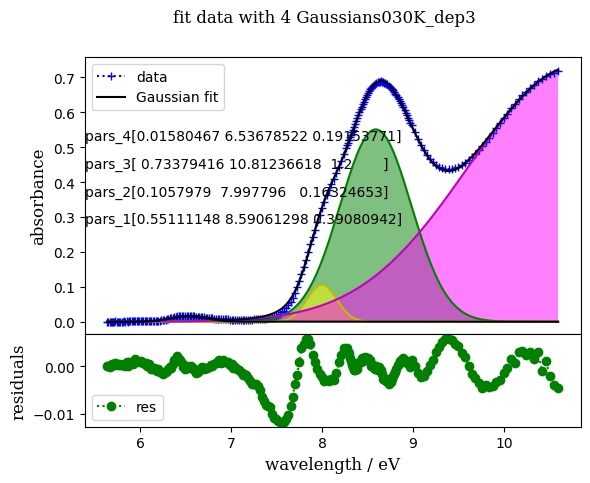

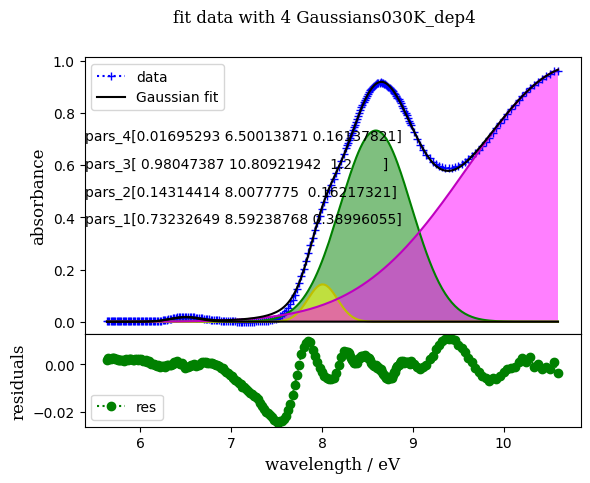

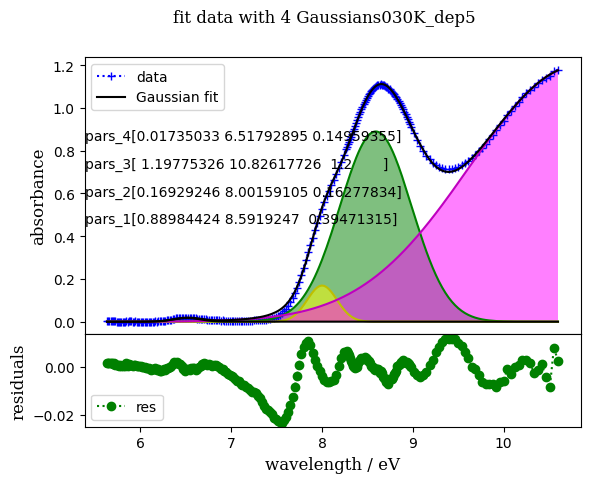

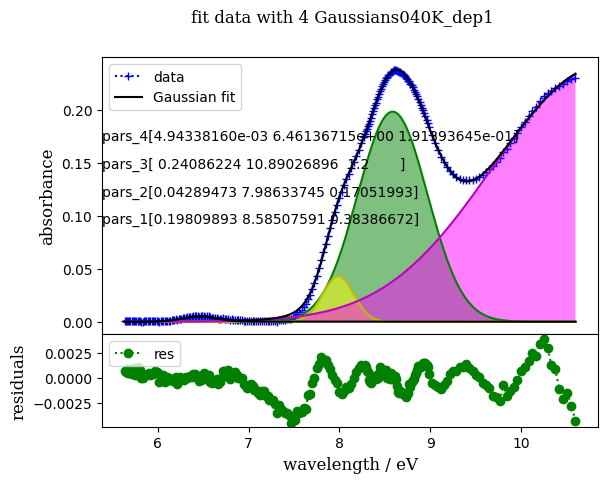

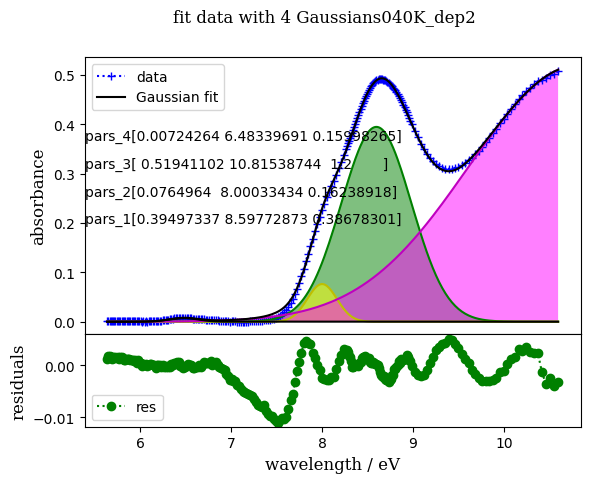

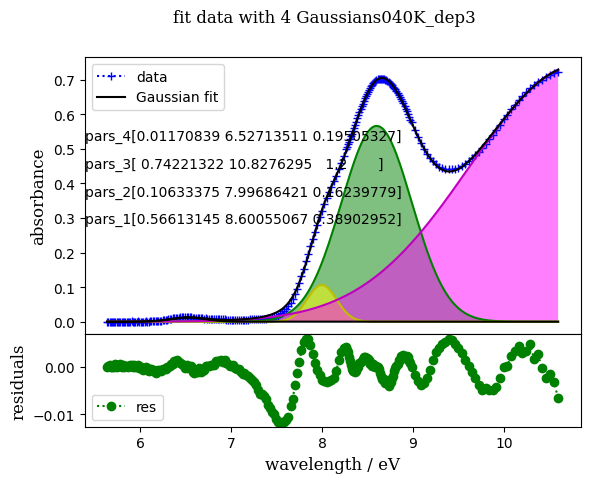

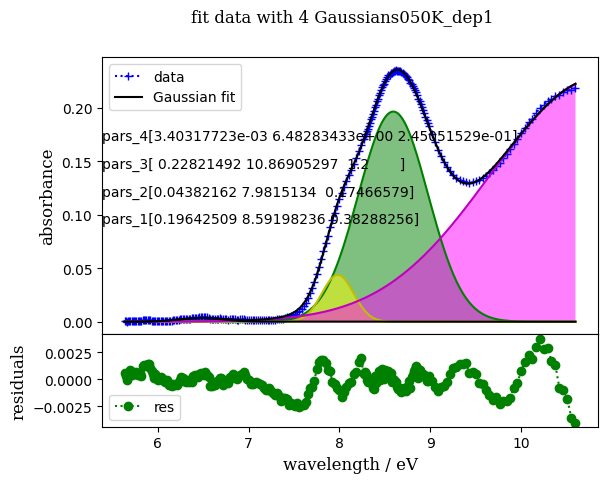

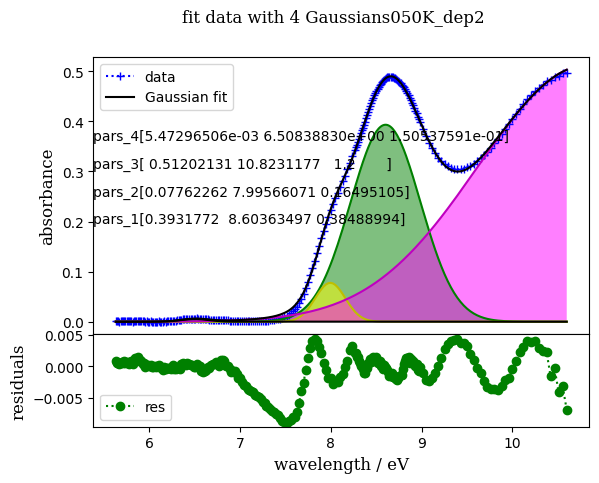

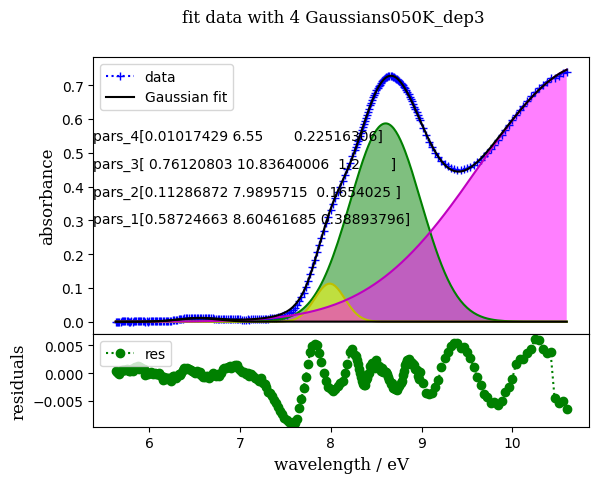

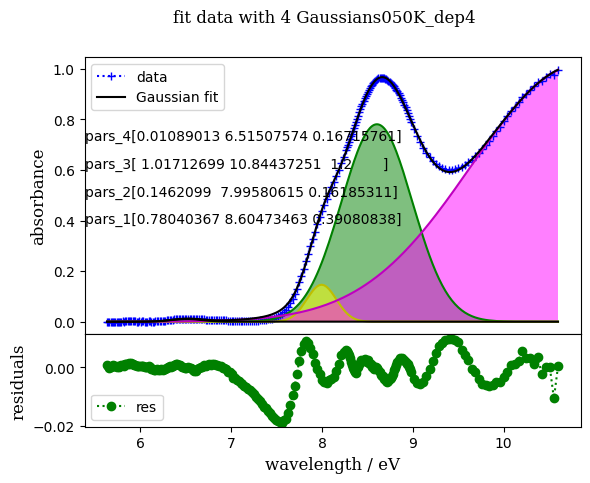

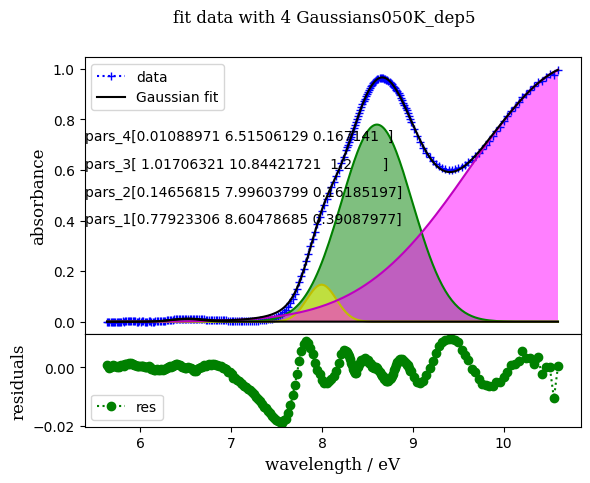

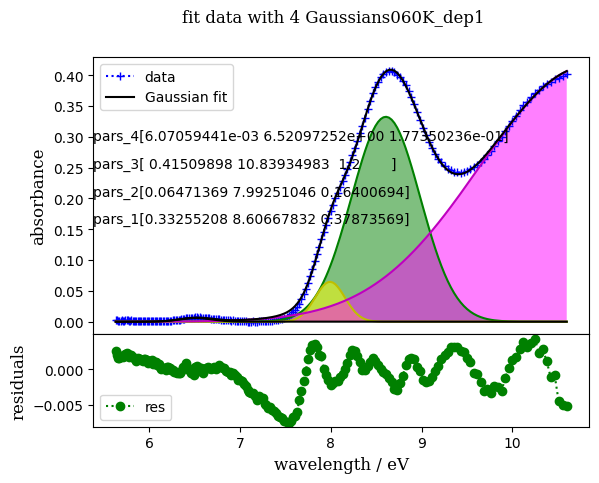

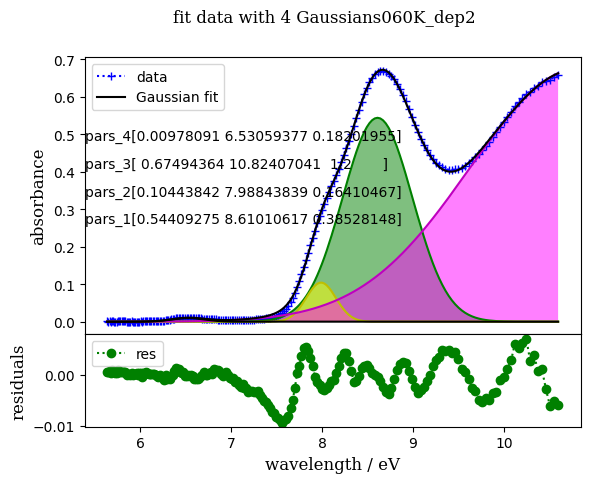

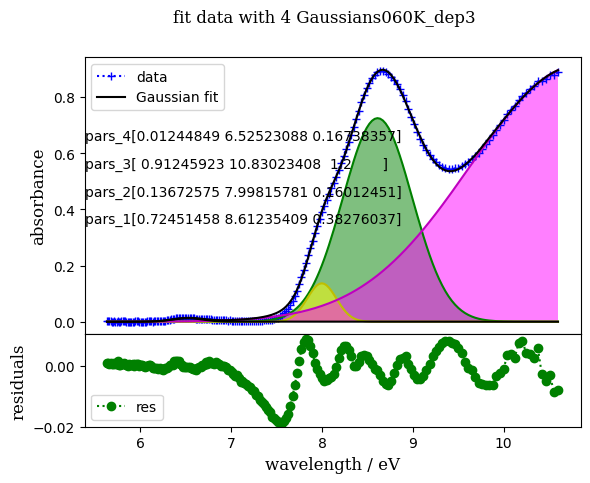

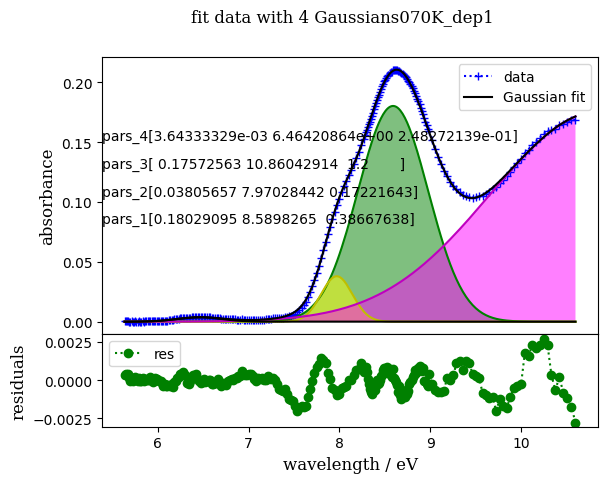

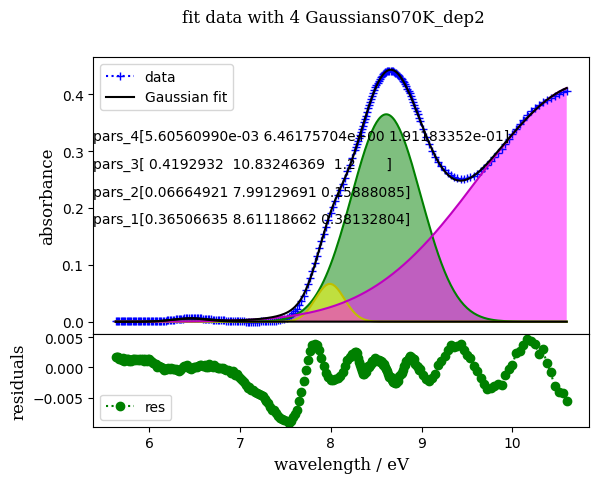

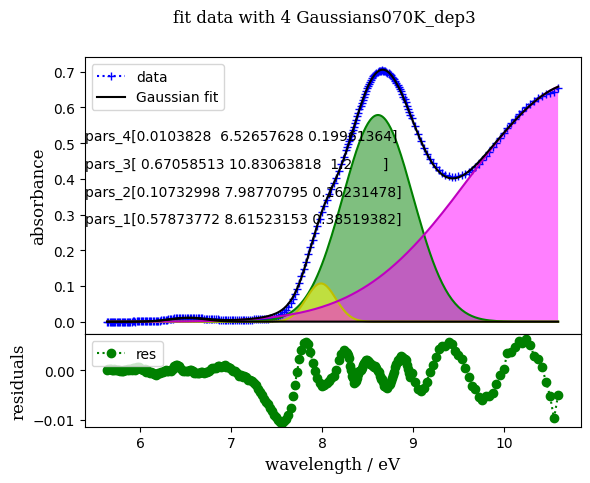

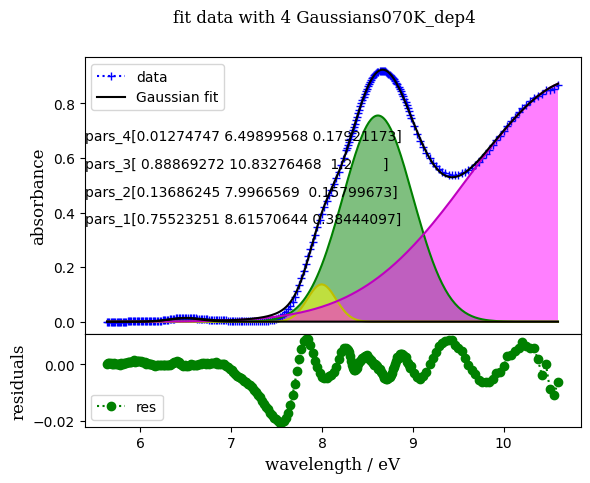

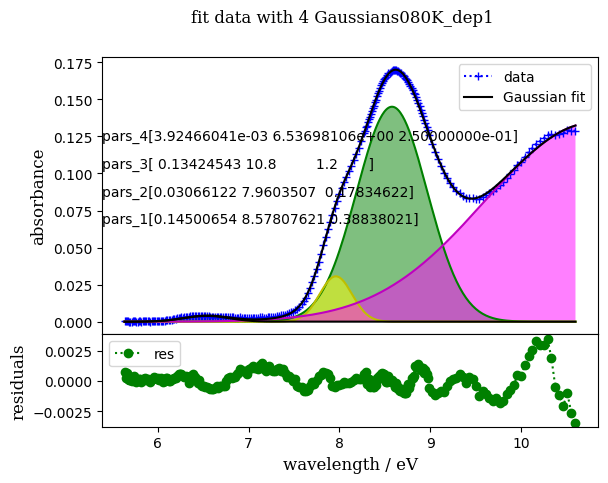

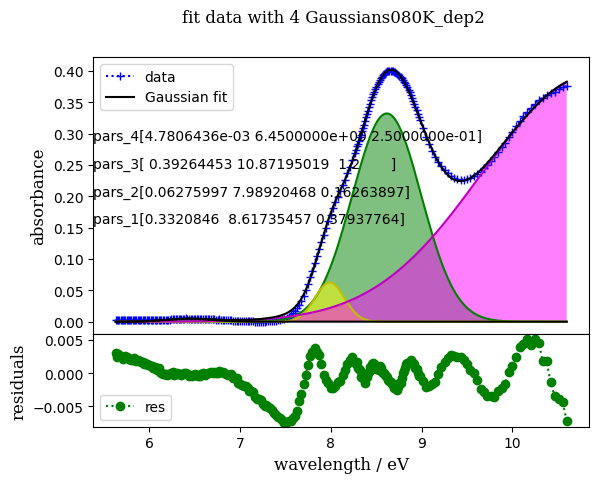

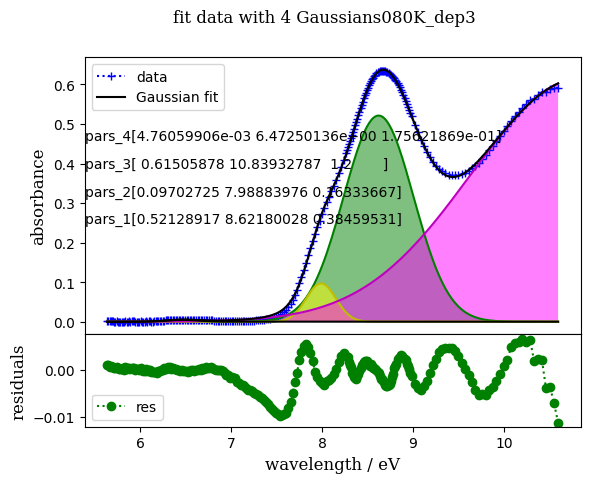

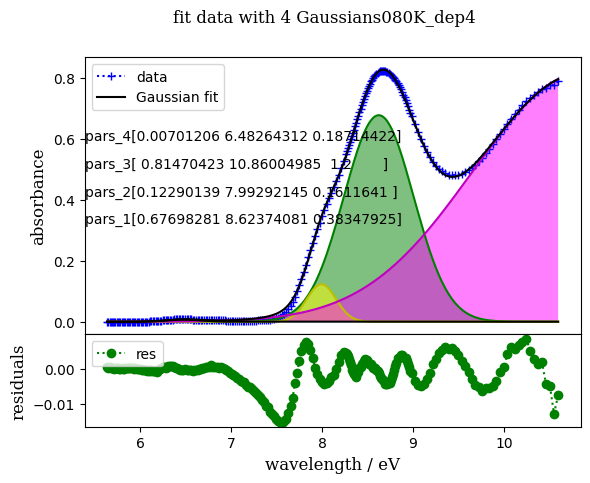

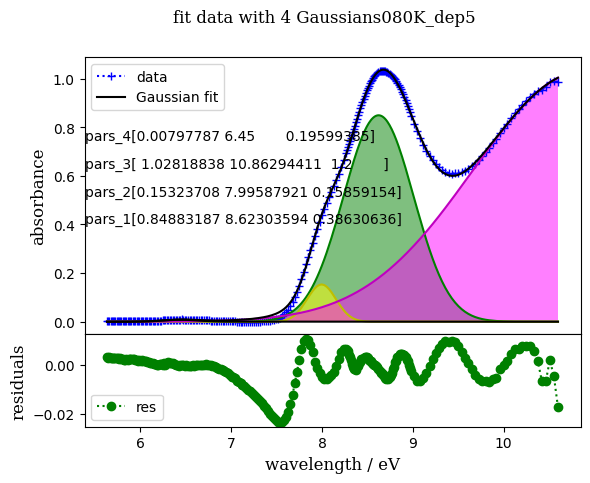

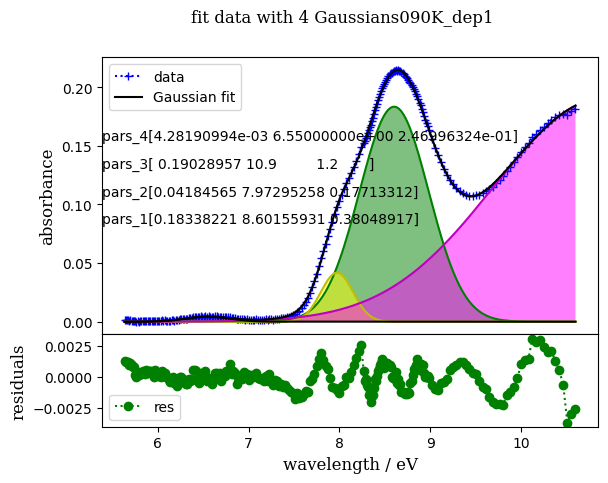

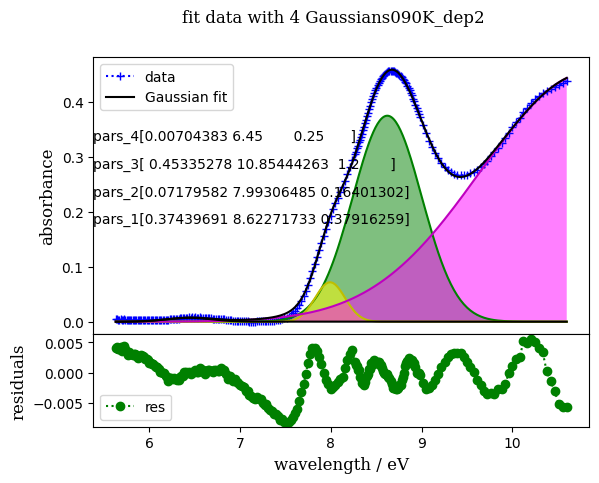

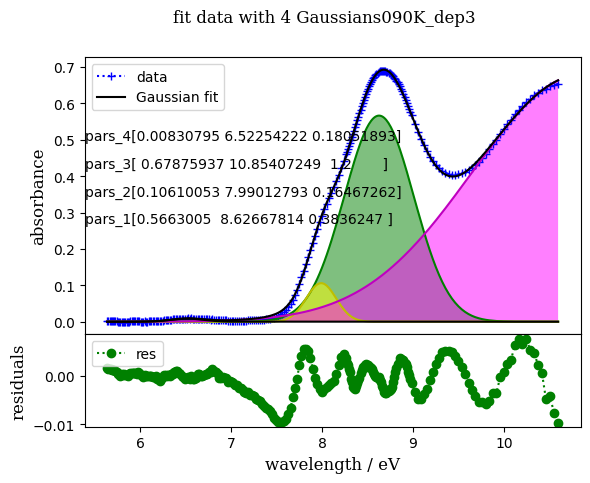

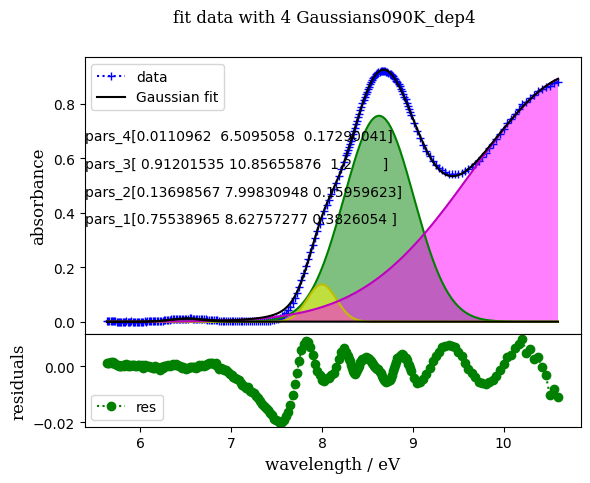

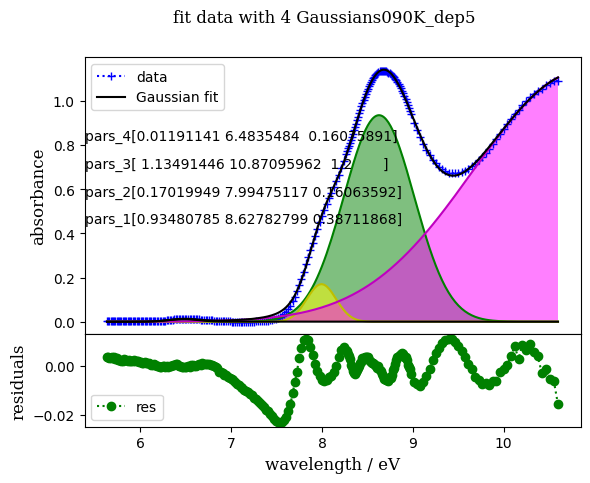

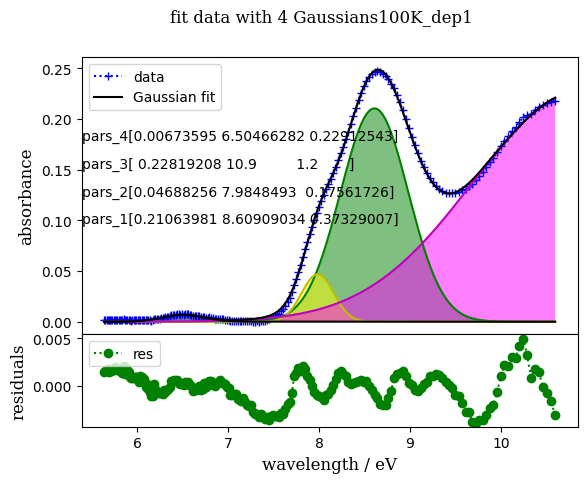

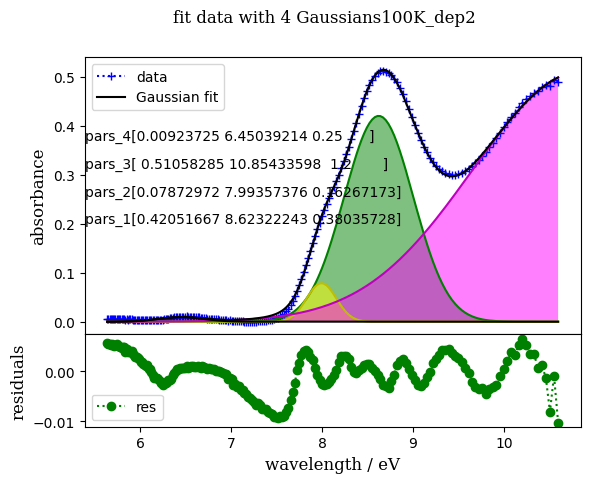

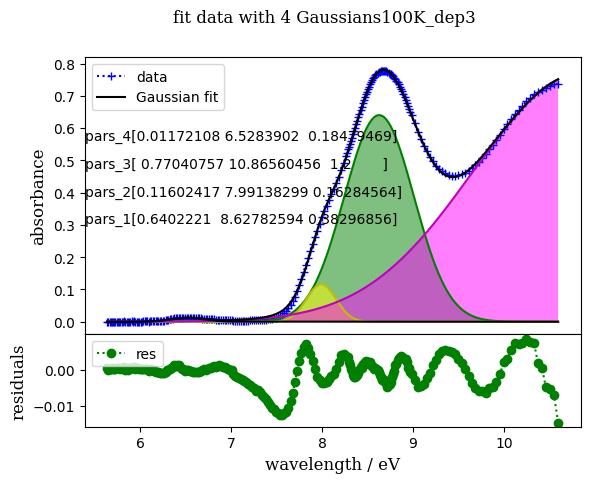

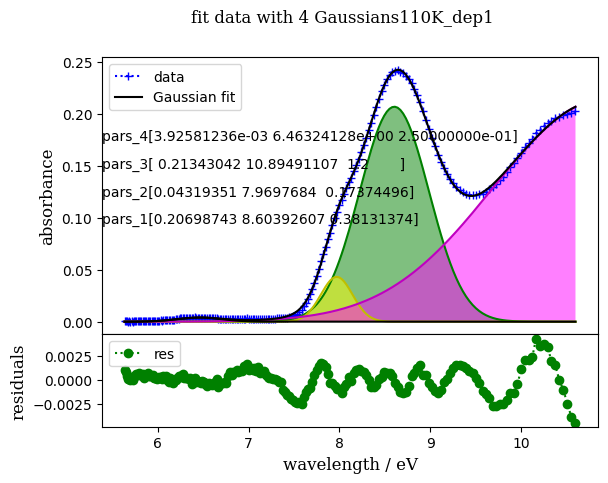

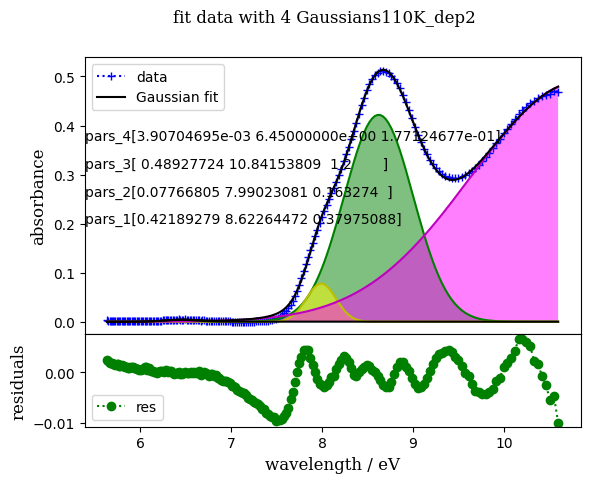

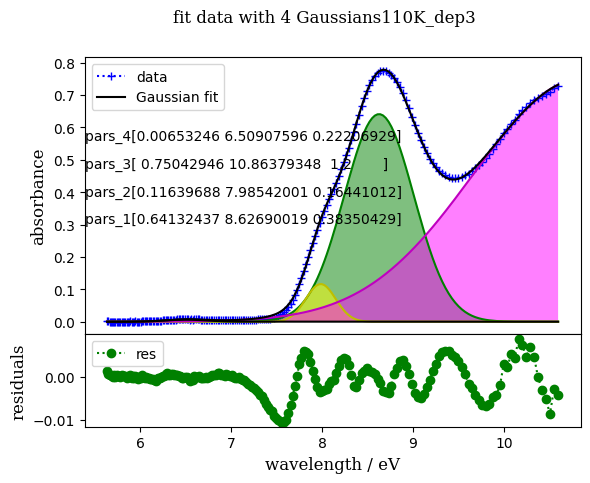

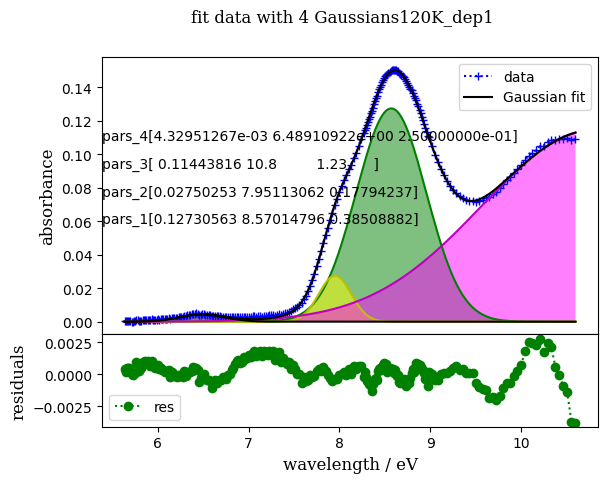

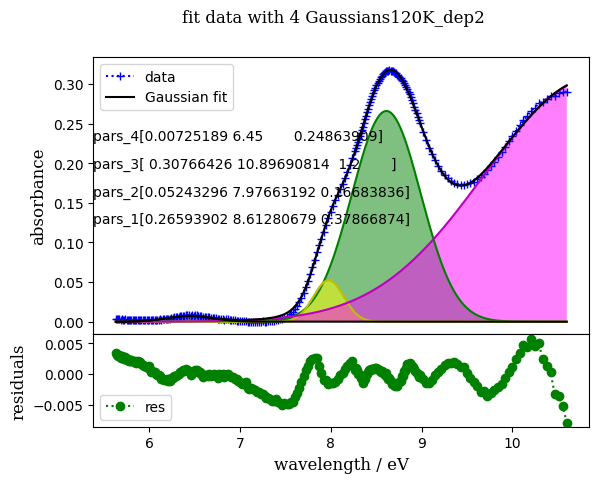

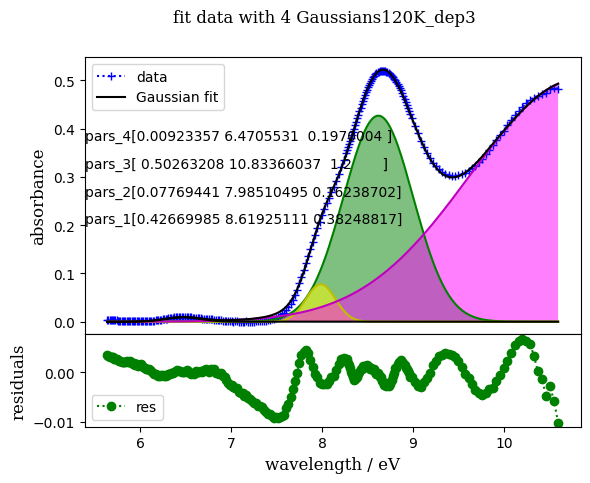

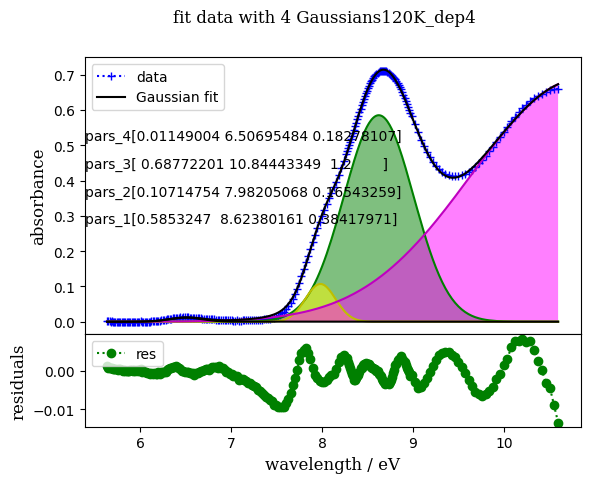

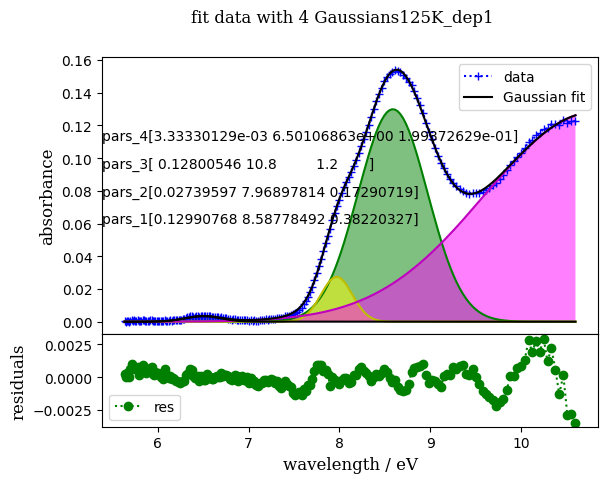

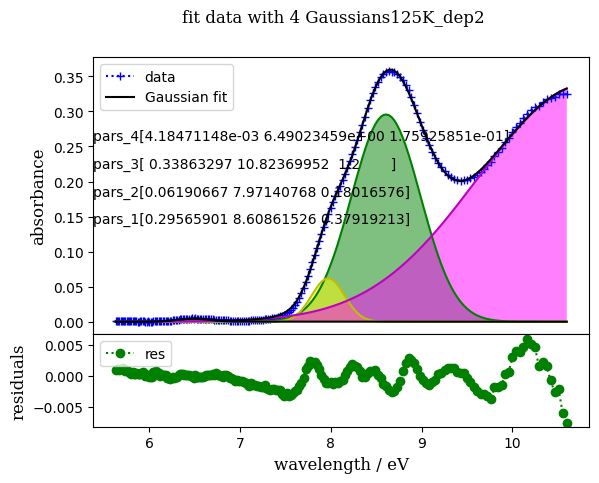

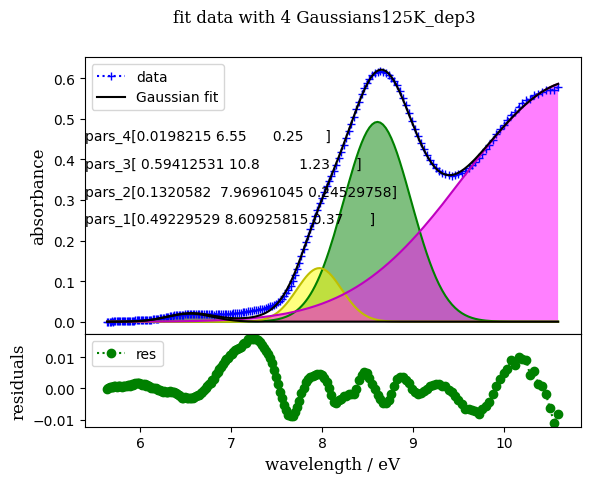

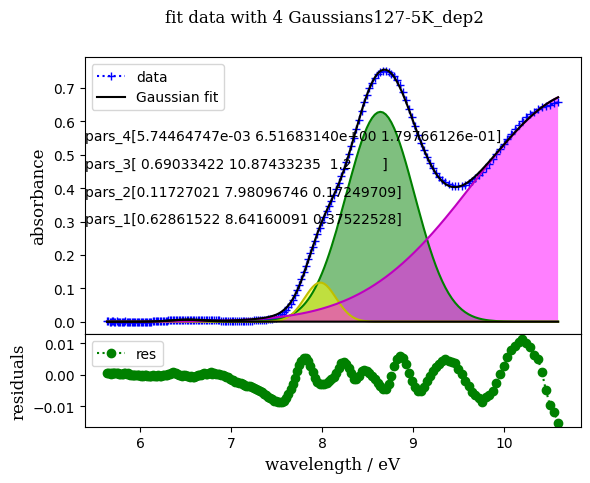

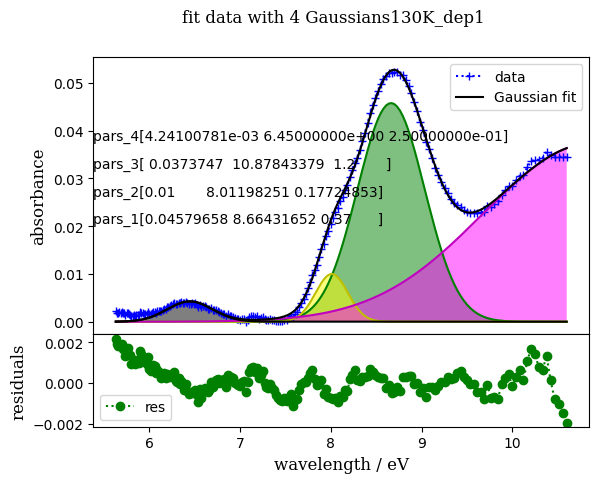

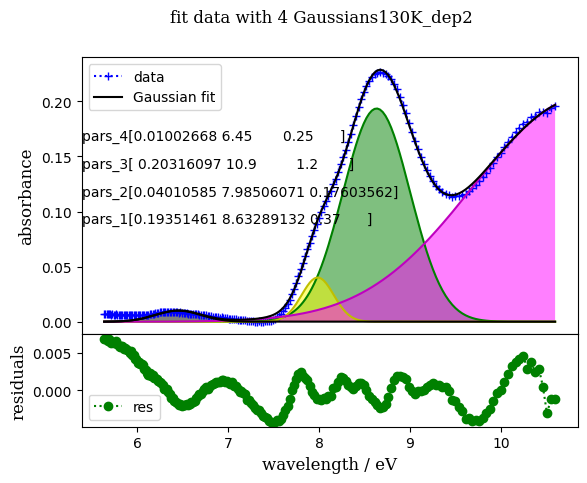

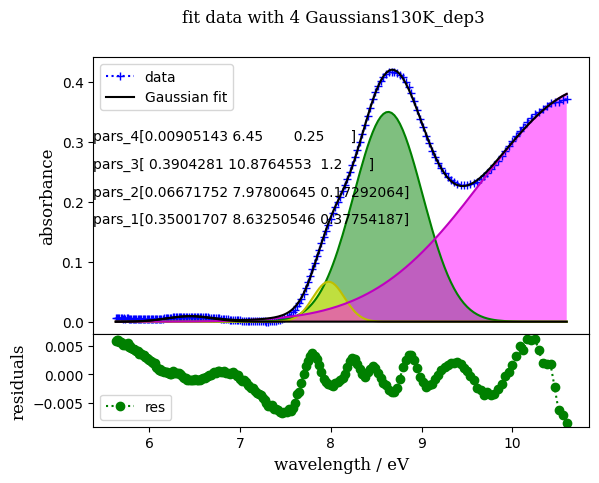

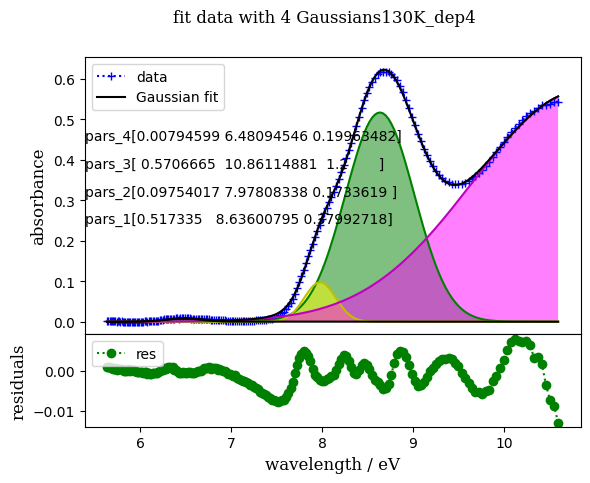

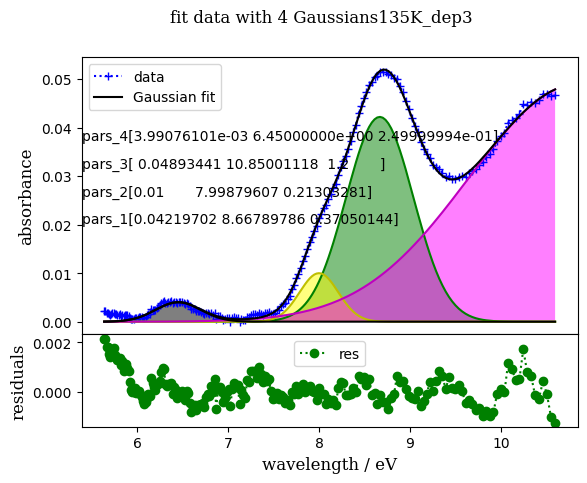

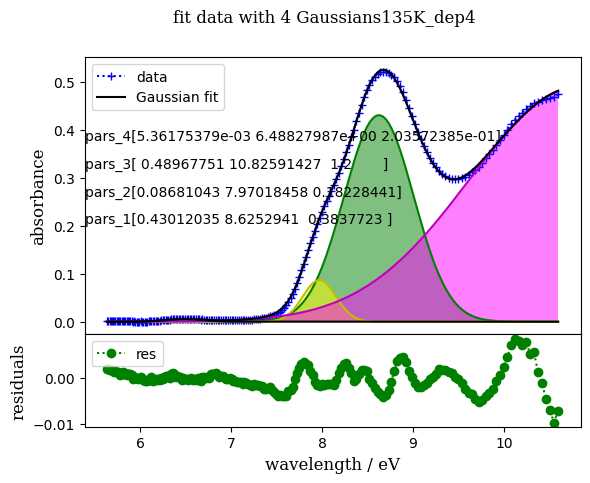

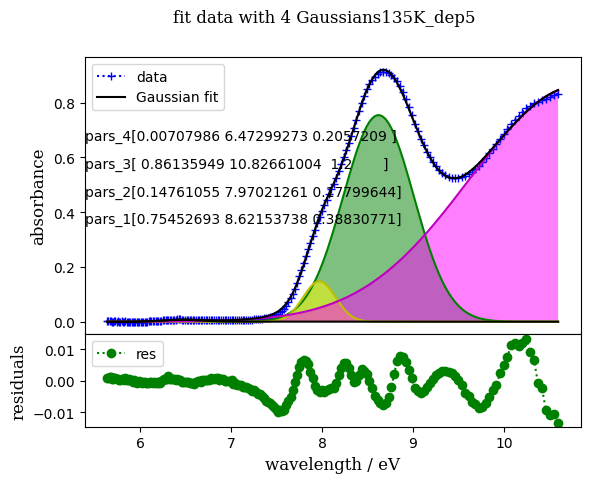

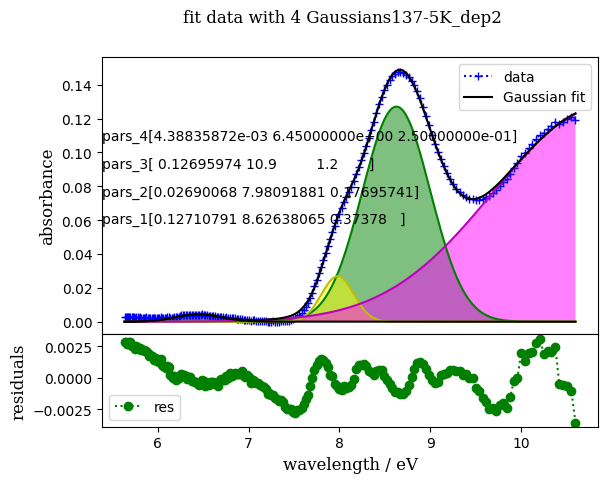

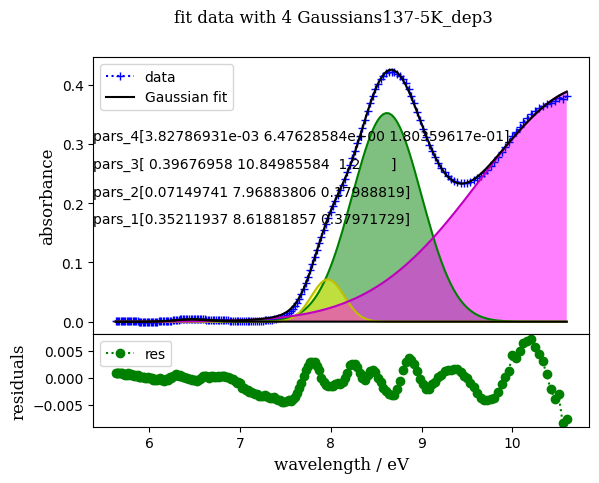

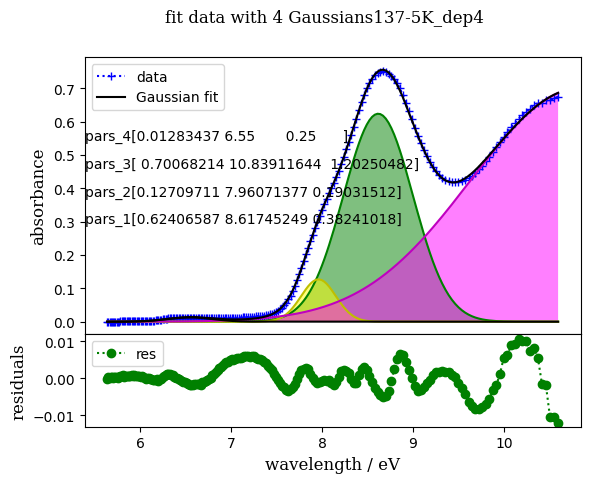

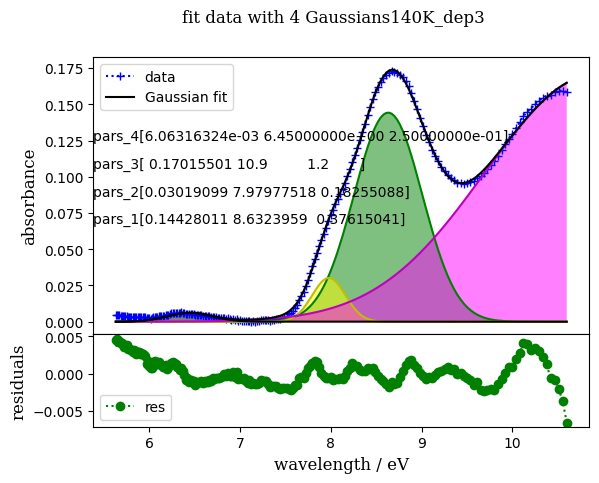

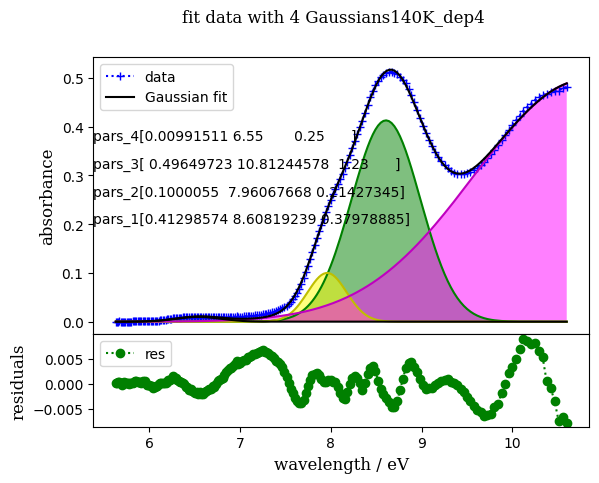

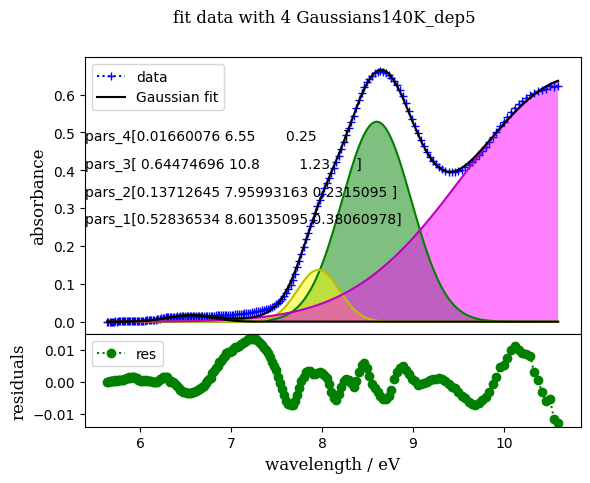

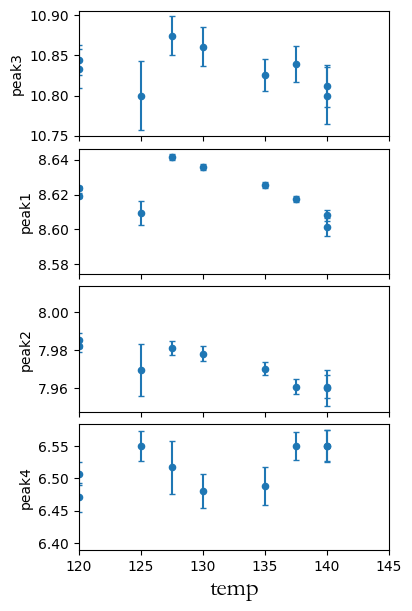

All data fitted


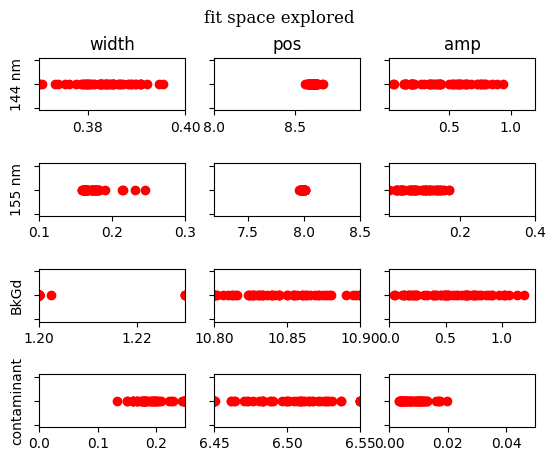

In [2]:

path = 'processed'
export_path='exports'

# glob processed files
temperatures = glob.glob(path)
data_files = glob.glob('processed/***.txt')

#   initial guess with bounds for eV fit
init_vals = [0.2, 8.6,0.38,
         0.05, 8.4, 0.172,
         0.3, 10.830, 1.22,
         0.05, 6.5, 0.174]

bounds_min = [0.01,8.0,0.37, # higher energy peak peak
              0.01,7.2,0.1, # lower energy peak 
              0,10.8,1.2, # background peak
              0,6.45,0] # v. low energy peak - to be ignored

bounds_max = [1.2,8.9,0.4,
              0.4,8.5,0.3,
              1.3,10.9,1.23,
              0.05,6.55,0.25]

#   create lists for data, temp & deposition
data_dict=[]
temp = []
depo = []
deltas = []

#   Load files and fit
#--------------------------------------------------------

for i in data_files:
    
    #   find temperature from data file name
    temperature = int(i[16:19])
    
    #   adjust for file naming - i.e. add  0.5 K to 127.5 and 137.5 K
    temperature = np.where((temperature==127 or temperature==137) , temperature+0.5, temperature)
    
    #   load data in dataframe
    df = pd.read_csv(i, delimiter=' ', names=['wavelength', 'absorbance'])
       
    #   find data file name
    name = i[16:-4]
    #   find deposition number from file name
    d = i.find('dep')
    deposition = int(i[d+3])

    #   discard data below 117 nm and above 220 nm
    df = df.drop(df[df['wavelength']<117].index)

    #   set a linear background by finding the minimum point on the curve and drawing a linear line here
    linear_BkGd=df['absorbance'].min()
    #   substract bkg
    y = df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
    
    #   make shorthand for wavelength
    x = WLtoE(df['wavelength'])

    #   fit Gaussian
    popt, pcov = curve_fit(multi_gaussian, x, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max))
    
    perr_3gauss = np.sqrt(np.diag(pcov))

    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    pars_3 = popt[6:9]
    pars_4 = popt[9:12]

    gauss_peak_1 = gaussian(x, *pars_1)
    gauss_peak_2 = gaussian(x, *pars_2)
    gauss_peak_3 = gaussian(x, *pars_3)
    gauss_peak_4 = gaussian(x, *pars_4)
    fit = gauss_peak_1 + gauss_peak_2 + gauss_peak_3 + gauss_peak_4
    
    #   calculate errors and residuals:
    df['residual_3gauss']=residual_2gauss = y - (multi_gaussian(x, *popt))
    df['Gauss_1'] = gauss_peak_1
    df['Gauss_2'] = gauss_peak_2
    df['Gauss_3'] = gauss_peak_3
    df['Gauss_4'] = gauss_peak_4
    df['Gauss_fit'] = fit
    residuals=sum((df['absorbance_bk']-(multi_gaussian(df['wavelength'], *popt)))**2)

    #   fit parameters
    #---------------------
    pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
    pars_err_2 = perr_3gauss[3:6]
    pars_err_3 = perr_3gauss[6:9]
    pars_err_4 = perr_3gauss[9:12]
    
    #   Concatenate fits
    Gauss = np.concatenate((pars_1, pars_err_1, pars_2, pars_err_2, pars_3, pars_err_3, pars_4, pars_err_4))

    #   Append Gaus, Temp and Dep to respective lists
    data_dict.append(Gauss)
    temp.append(temperature)
    depo.append(deposition)
    
    #  Save the dataframe to csv file    
    df.to_csv('exports/'+name+'.csv', index=False)

    ### Outputs from Gaussian fits are usually turned off
    ##. a. plot 
    PlotGaussFit(name, x, df['absorbance_bk'], fit, df['residual_3gauss'], gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4)
    ##. b. get ratio between peak areas
    #print("The ratio of low energy peak / high energy peak is:", gaussian_area(popt[0], popt[3])/gaussian_area(popt[4], popt[6]))  

###
### 2. put all of the fit outcomes into a dataframe called "p"
###

data_dict = np.array(data_dict)
temp = np.array(temp)
depo = np.array(depo)
data = np.round(np.concatenate((temp[:,None], depo[:,None],data_dict), axis=1),8)
data_dict=dict(enumerate(data,0))

p = pd.DataFrame(data, columns=['temp','dep',
                                'ab1','peak1','sig1','ab1_err','peak1_err','sig1_err',
                                'ab2','peak2','sig2','ab2_err','peak2_err','sig2_err',
                                'ab3','peak3','sig3','ab3_err','peak3_err','sig3_err',
                                'ab4','peak4','sig4','ab4_err','peak4_err','sig4_err'])
p.to_csv('gaussian_fits.csv', index=False)

### 2.b   Plot fit outcomes and parameter space explored, if required
### ------------------------------

PlotGauss_PeakMax(p)
PlotFitSpace(p)

###
### 3. The data at 125 K are time resolved and need to be analysed seperately
###
# glob processed files
data_files = glob.glob('time/data/***.txt')
#   initial guess with bounds for eV fit
init_vals = [0.2, 8.6,0.38, #amp, pos, width
         0.05, 8.4, 0.172,
         0.3, 11.830, 1.22,
         0.029, 6.4, 0.21]

bounds_min = [0.01,8.0,0.37, # 8 eV peak
              0.01,7.2,0.1, # 7 eV peak
              0,10.9,1.0, # high energy background peak
              0.00,6.0,0.2] # low energy peak

bounds_max = [1.2,8.9,0.4,
              0.4,8.5,0.3,
              1.3,11.9,1.23,
              0.1,7.0,0.4]

#   create lists for data, temp & deposition
data_dict=[]
time_stamps = []

#   Load files and fit
#--------------------------------------------------------

for i in data_files:
       
    #   find time stamp from data file name
    time = int(i[-8:-4])
    
    #   load data in datafram
    df = pd.read_csv(i, delimiter=' ', names=['wavelength', 'absorbance'])

    #   discard data below 117 nm and above 220 nm
    df = df.drop(df[df['wavelength']<117].index)

    #   set a linear background by finding the minimum point on the curve and drawing a linear line here
    linear_BkGd=df['absorbance'].min()
    #   substract bkg
    y = df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
    
    # #make shorthand for wavelength
    x = WLtoE(df['wavelength'])

    #   fit Gaussian
    popt, pcov = curve_fit(multi_gaussian, x, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max))
    
    perr_3gauss = np.sqrt(np.diag(pcov))

    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    pars_3 = popt[6:9]
    pars_4 = popt[9:12]
    gauss_peak_1 = gaussian(x, *pars_1)
    gauss_peak_2 = gaussian(x, *pars_2)
    gauss_peak_3 = gaussian(x, *pars_3)
    gauss_peak_4 = gaussian(x, *pars_4)
    fit = gauss_peak_1 + gauss_peak_2 + gauss_peak_3 + gauss_peak_4
    
    #calculate errors and residuals:
    df['residual_3gauss']=residual_2gauss = y - (multi_gaussian(x, *popt))
    df['Gauss_1'] = gauss_peak_1
    df['Gauss_2'] = gauss_peak_2
    df['Gauss_3'] = gauss_peak_3
    df['Gauss_4'] = gauss_peak_4
    df['Gauss_fit'] = fit
    residuals=sum((df['absorbance_bk']-(multi_gaussian(df['wavelength'], *popt)))**2)

    #   fit parameters
    #---------------------
    pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
    pars_err_2 = perr_3gauss[3:6]
    pars_err_3 = perr_3gauss[6:9]
    pars_err_4 = perr_3gauss[9:12]
    
    #   Concatenate fits
    Gauss = np.concatenate((pars_1, pars_err_1, pars_2, pars_err_2, pars_3, pars_err_3, pars_4, pars_err_4))

    #   Append Gaus, Time and Dep to respective lists
    data_dict.append(Gauss)
    time_stamps.append(time)
    
    ### Outputs from Gaussian fits are usually turned off
    #PlotGaussFit(str(time)+ 's', x, df['absorbance_bk'], fit, df['residual_3gauss'], gauss_peak_1,gauss_peak_2,gauss_peak_3,gauss_peak_4)
    
    # Save the dataframe to csv file
    
#put all of the fit outcomes into a dataframe called "time_p"
data_dict = np.array(data_dict)
time_stamps = np.array(time_stamps)
data = np.round(np.concatenate((time_stamps[:,None], data_dict), axis=1),8)
data_dict=dict(enumerate(data,0))

time_p = pd.DataFrame(data, columns=['time',
                                'ab1','peak1','sig1','ab1_err','peak1_err','sig1_err',
                                'ab2','peak2','sig2','ab2_err','peak2_err','sig2_err',
                                'ab3','peak3','sig3','ab3_err','peak3_err','sig3_err',
                                'ab4','peak4','sig4','ab4_err','peak4_err','sig4_err'])
time_p['temp']  =125.0
time_p['dep']  =3.0

time_p.to_csv('time_data_fits.csv', index=False)
extract_125K_last = time_p.iloc[[-1]].copy()
extract_125K_last.reset_index(drop=True, inplace=True)

### 3b. Replace the data at 125 K with the last point in the time resovled data

##Find depositions at same thickness/absorbance for each temperature and save results
obs_all_data = p.loc[(p['ab1'] > 0.41) & (p['ab1'] < 0.71), ['temp','dep','peak1','peak2', 'peak1_err','peak2_err']]

#Replace the fit at 125 K with the better fit from the time-resolved data
# Get the columns of obs_all_data
obs_all_data_columns = obs_all_data.columns
# Filter extract_125K_last to only contain columns present in obs_all_data
filtered_extract_125K_last = extract_125K_last[obs_all_data_columns]
# Replace the values in obs_all_data with values from filtered_extract_125K_last
condition = (obs_all_data['temp'] == 125) & (obs_all_data['dep'] == 3)
obs_all_data.loc[condition, obs_all_data_columns] = filtered_extract_125K_last.values

print('All data fitted')

## To fit peak position as a function of film thickness

C:\Users\au302163\AppData\Local\Temp\ipykernel_30444\537743696.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_data, y_data, order)
C:\Users\au302163\AppData\Local\Temp\ipykernel_30444\537743696.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_data, y_data, order)
C:\Users\au302163\AppData\Local\Temp\ipykernel_30444\537743696.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  Fig1.show()


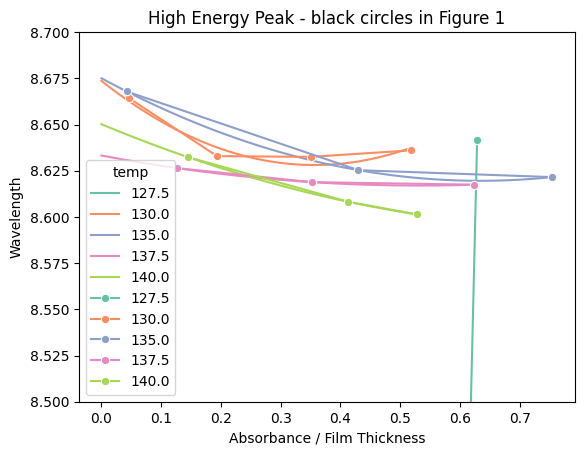

In [10]:
## To fit a polynomial to peak position data as a function of film thickenss(aka absorbance). 
## Aim is to get peak potision at zero absorbance

# define polynomial function that auto scan through data in dataframe called "p"
def fit_polynomial_same_temp(df, x_col, y_col, temp_col, order):
    poly_data = pd.DataFrame()
    # Group the DataFrame by the temperature column and iterate over each group
    for temp, group in df.groupby(temp_col):
        
        # Extract the x and y data
        x_data = group[x_col]
        y_data = group[y_col]
        
        #print('xdata\n',x_data)
        #print('ydata\n',y_data)
        
        # Fit the polynomial
        coefficients = np.polyfit(x_data, y_data, order)

        # Create the polynomial function
        polynomial_func = np.poly1d(coefficients)
        
        # Print the polynomial function for this temperature
        #print(f"Polynomial function for {temp_col}={temp}:")
        #print(polynomial_func)
        #print("\n")
        
        # Generate x values for the plot
        x_plot = np.linspace(0, max(x_data), 400)

        # Compute y values for the plot
        y_plot = polynomial_func(x_plot)
        
        temp_data = pd.DataFrame({
            'x_plot': x_plot,
            'y_plot': y_plot,
            'temp': temp
        })
        poly_data = pd.concat([poly_data, temp_data])
        

    return poly_data

poly_data_high = fit_polynomial_same_temp(p, 'ab1', 'peak1', 'temp', 2) # for the high energy peak - black circles in figure 1
poly_data_low = fit_polynomial_same_temp(p, 'ab2', 'peak2', 'temp', 2) # for the low energy peak - red triangles in figure 1

#print(poly_data.loc[poly_data.temp<127])

#fig, axs = plt.subplots(2, 1, sharex=False, figsize=(4,6)) # I am making a 2 x 1 row x column grid
#fig.subplots_adjust(hspace=0.4)

Fig1 = plt.figure()
poly_data_high_reset = poly_data_high.reset_index()
poly_data_low_reset = poly_data_low.reset_index()

sns.lineplot(data=poly_data_high_reset.loc[poly_data_high_reset.temp>127], palette = "Set2",x='x_plot', y='y_plot',hue='temp')
sns.lineplot(data=p.loc[p.temp>127], palette = "Set2", x='ab1',y='peak1', marker='o', hue='temp')

plt.title('High Energy Peak - black circles in Figure 1')
plt.xlabel('Absorbance / Film Thickness')
plt.ylabel('Wavelength')
plt.ylim(8.5,8.7)
# Save the plot
Fig1.savefig('Figure_supmat_high energy_E0_highTemp.png', dpi = 600, bbox_inches='tight',format='png')
Fig1.savefig('Figure_supmat_high energy_E0_highTemp.svg',dpi = 600, bbox_inches='tight',format='svg')

Fig1.show()
#plt.close(Fig1)

Fig2 = plt.figure()
sns.lineplot(data=poly_data_low_reset.loc[poly_data_low_reset.temp<127], palette = "Set2",x='x_plot', y='y_plot',hue='temp')
sns.lineplot(data=p.loc[p.temp<127], palette = "Set2", x='ab2',y='peak2', marker='o', hue='temp')

plt.title('Low Energy Peak - red triangles in Figure 1')
plt.xlabel('Absorbance / Film Thickness')
plt.ylabel('Wavelength')

# Show the plot
Fig2.savefig('Figure_supmat_low energy_E0_highTemp.png', dpi = 600, bbox_inches='tight',format='png')
Fig2.savefig('Figure_supmat_low energy_E0_highTemp.svg',dpi = 600, bbox_inches='tight',format='svg')

plt.close(Fig2)




